#  Статистический анализ данных сервиса аренды самокатов GoFast 

В нашем распроряжении данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти. Перечень гипотез, проверяемых в данной работе, приведен ниже в разделе "Проверка гипотез".

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
  - абонентская плата отсутствует;
  - стоимость одной минуты поездки — 8 рублей;
  - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
  - абонентская плата — 199 рублей в месяц;
  - стоимость одной минуты поездки — 6 рублей;
  - стоимость старта — бесплатно.
  
Ход выполнения работы:
1. Загрузить данные. Изучите общую информацию о каждом датафрейме.
2. Провести предобработку данных. Проверить наличие пропущенных значений и дубликатов в датафреймах. Привести формат даты к datetime. Создать столбец с номером месяца на основе столбца с датой поездки.
3. Провести исследовательский анализ данных.- Оцененить и визуализировать частоту встречаемости городов, соотношение пользователей с подпиской и без подписки, возраст пользователей, расстояние, которое пользователь преодолел за одну поездку и продолжительность поездок. 
4. Объединить данные из трёх датасетов в один общий. После чего на его основе создать два датасета с данными о пользователях с подпиской и без неё.
5. Произвести подсчёт выручки. Создать сводную таблицу о суммарном расстоянии, количестве поездок и суммарном времени для каждого пользователя за каждый месяц. Добавить столбец в данную таблицу с помесячной выручкой, но перед этим произвести округление значений в столбце с продолжительностью поездки в исходном датасете.
6. Произвести проверку гипотез с помощью t-тестов:
- Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе
- Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку
- Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки
7. Определить минимальное количество промокодов, которые нужно разослать, чтобы как минимум 100 существующих клиентов должны продлить эту подписку и вероятность не выполнить план была примерно 5 %. А так же, оцененить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей из 1 млн разосланный уведомлений с вероятностью открытия 40%. 


**Для ознакомления с данными и дальнейшего их анализа импортируем библиотеки**

In [1]:
import pandas as pd
from scipy import stats as st
from scipy.stats import binom, norm
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
display(users.tail())

,user_id,name,age,city,subscription_type
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra
1564,1045,Артемий,28,Ростов-на-Дону,free


В файле users содержится следующаяя информация:
- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free - без подписки, ultra - с подпиской)

In [3]:
rides = pd.read_csv('/datasets/rides_go.csv')
display(rides.tail())

,user_id,distance,duration,date
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27
18067,1534,2371.711192,15.893917,2021-12-29


В файле rides содержится следующаяя информация:
- user_id  - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки

In [4]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В файле subscriptions_go содержится следующаяя информация:
- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

**Ознакомимся с информацией о данных**

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Пропусков в данных не обнаружено. Перевод форматов данных не требуется.

In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Пропусков в данных не обнаружено. Требуется перевод формата данных о дате поездки в формат datetime.

In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Пропусков в данных не обнаружено. Перевод форматов данных не требуется.

**Ознакомимся со сводной статистикой данных**

In [8]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1565.0,762.633866,443.260155,1.0,378.0,762.0,1146.0,1534.0
age,1565.0,24.922045,4.553496,12.0,22.0,25.0,28.0,43.0


Исходя из таблицы со сводной статистикой о пользователях сервиса можно увидеть, что минимальный возраст пользователя - 12 лет, а максимальный - 43 года. Медианный возраст пользователя - 25 лет. 

In [9]:
rides.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,18068.0,842.869936,434.734317,1.000000,487.000000,889.000000,1213.250000,1534.000000
distance,18068.0,3070.659976,1116.831209,0.855683,2543.226360,3133.609994,3776.222735,7211.007745
duration,18068.0,17.805011,6.091051,0.500000,13.597563,17.678395,21.724800,40.823963


Минимальное расстояние, проезжаемое пользователями примерно 86 см, что может быть обусловлено нежеланием пользователя продолжать поездку или тем, что выбранный пользователем самокат мог быть разряженным. Медианное расстояние, проезжаемое пользователями сервися 3,134 км, а максимальное же - 7,211 км.  

#### Шаг 2. Предобработка данных

Приведем формат даты в файле с информацией о поездках (rides) в формат datetime

In [10]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Создаём новый столбец с номером месяца на основе столбца date

In [11]:
rides['month'] = rides['date'].dt.month 

Проверка дат поездок, а именно определение года - периода, за который у нас есть данные. 

In [12]:
rides['date'].dt.year.unique() 

array([2021])

Данные за 2021 год, поэтому номер месяца соответствует номеру месяца 2021 года.

**Работа с дубликатами**

Найдём количество явных дубликатов в файлах, предоставляенных на исследование:

In [13]:
users.duplicated().sum()

31

В файле users обнаружен 31 дубликат. Удалим эти дубликаты.

In [14]:
users = users.drop_duplicates()

In [15]:
rides.duplicated().sum()

0

В файле rides явные дубликаты не обнаружены.

In [16]:
subscriptions.duplicated().sum()

0

В файле subscriptions явные дубликаты не обнаружены.

Неявные дубликаты могут быть в файле users в столбце с городами, обусловленные некорреректной записью города.

In [17]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Разной записи одних и тех же городов не обнаружено. Следовательно, обрабатывать города не требуется. Соответственно, все дубликаты, присутствующие в предоставленных на исследование данных обработаны, т.е. удалены.

#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках.
Начнем **с частоты встречаемости городов.**

In [18]:
sities = users['city'].value_counts()
sities

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

В файле users представлены данные о пользователях из следующих городов:
- Пятигорск,
- Екатеринбург,
- Ростов-на-Дону,
- Краснодар,
- Сочи,
- Омск,
- Тюмень,
- Москва.

Наибольшее количество пользователей сервисом в Пятигорске (219), наименьшее - в Москве (168).

Получим процентное распределение пользователей сервиса по городам.

In [19]:
sities['part'] = round(users['city'].value_counts()/ sities.sum(),4)*100
sities['part']

Пятигорск         14.28
Екатеринбург      13.30
Ростов-на-Дону    12.91
Краснодар         12.58
Сочи              12.32
Омск              11.93
Тюмень            11.73
Москва            10.95
Name: city, dtype: float64

14.28% пользователей из Пятигорска, а из Москвы - 10.95%

Визуализируем полученные даннные. Для начала построим столбчатую диаграмму для абсолютных значений числа пользователей сервисом.

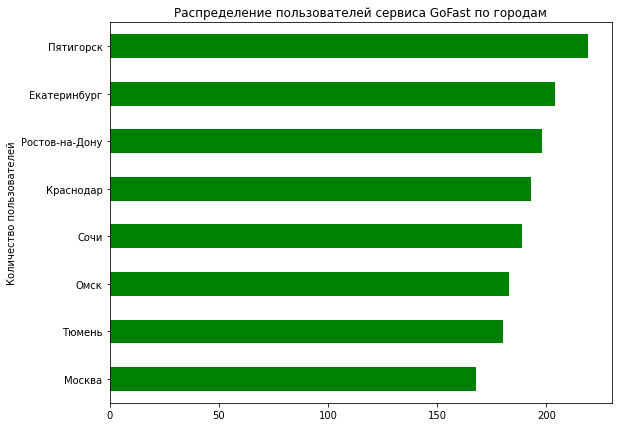

In [20]:
users['city'].value_counts(ascending=True).plot(
    kind = 'barh', 
    y = sities,
    figsize=(9,7), 
    color = 'green',
    title = 'Распределение пользователей сервиса GoFast по городам',
    xlabel = 'Количество пользователей',
    ylabel= 'Названия городов');

Построим круговую диаграмму для процентного распределения пользователей сервисом по городам.

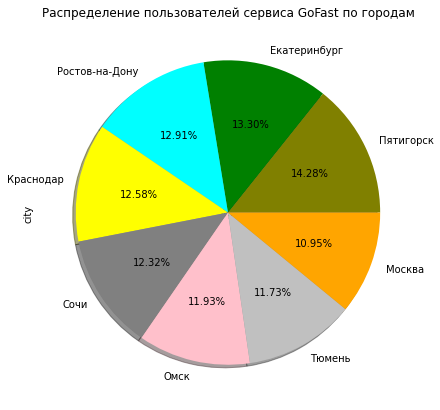

In [21]:
users['city'].value_counts().plot(
    kind = 'pie', 
    y = sities,
    autopct='%1.2f%%',
    colors=['olive', 'green', 'cyan', 'yellow', 'grey', 'pink', 'silver', 'orange'], 
    shadow=True,
    figsize=(9,7), 
    title = 'Распределение пользователей сервиса GoFast по городам');

Из круговой диаграммы хорошо видно, что в среднем пользователи равномерно распределились по городам, без силььного перекоса числа пользователей в каком - то из городов. Есть небольшое смещение в количестве пользователей в Пятигорске и в Москве. В Пятигорске большее количество пользователей, скорее всего, обусловлено тем, что, это небольшой курортный город, в котором туристам удобнее передвигаться между достопримечательностями на самокате. В Москве же меньшее количество пользователее, скорее обусловлено, тем, что в столице существуют и другие сервисы проката самокатов, соответственно присутствует конкуренция за пользователей.   

**Соотношение пользователей с подпиской и без подписки.**

In [22]:
#соотношение пользователей в абсолютных значениях
subs = users['subscription_type'].value_counts()
subs

free     835
ultra    699
Name: subscription_type, dtype: int64

Пользователей без подписки на 136 человек больше, чем с подпиской. Это может быть обусловлено тем, что не всем пользователям нужно часто передвигаться на самокате, поэтому подписка на сервис им не нужна. 

Рассмотрим процентное соотношение пользователей с подпиской и без неё.

In [23]:
#соотношение пользователей в процентных значениях
subs['subscription_type'] = round(users['subscription_type'].value_counts()/ subs.sum(),4)*100
subs['subscription_type']

free     54.43
ultra    45.57
Name: subscription_type, dtype: float64

Визуализируем полученные данные. Начнём с абсолютных значений распроеделения пользователей сервисом с подпиской и без неё.

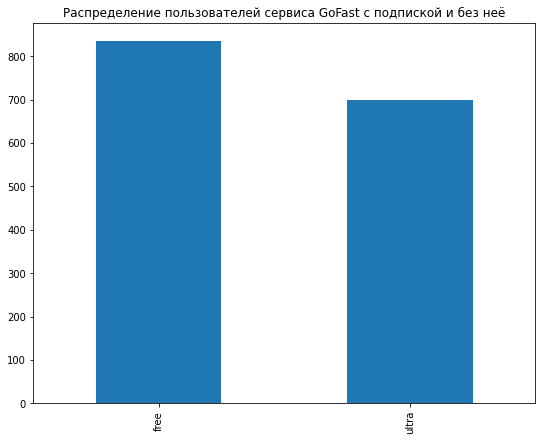

In [24]:
users['subscription_type'].value_counts().plot(
    kind = 'bar', 
    y = subs,
    figsize=(9,7), 
    title = 'Распределение пользователей сервиса GoFast с подпиской и без неё');

Для более наглядного представления данных о пользователях воспользуемся процентным соотношением и визуализируем его в виде круговой диаграммы.

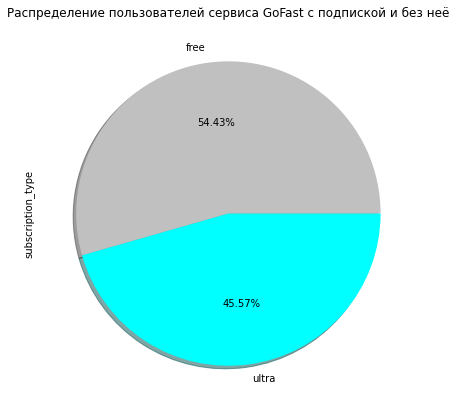

In [25]:
users['subscription_type'].value_counts().plot(
    kind = 'pie', 
    y = subs,
    autopct='%1.2f%%',
    colors=['silver', 'cyan'], 
    shadow=True,
    figsize=(9,7), 
    title = 'Распределение пользователей сервиса GoFast с подпиской и без неё');

На диаграмме отчётливо видно, что количество пользователей без подписки на 9% больше, чем с подпиской. Как было подмечено мной ранее, это может быть обусловлено тем, что не всем пользователям нужно часто передвигаться на самокате, поэтому подписка на сервис им просто не нужна.

**Возраст пользователей сервиса**

Ранее при ознакомлении с данными, предоставленными на анализ, была задана таблица со сводной статистикой. Вызовем её еще раз. 

In [26]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1534.0,767.50000,442.971971,1.0,384.25,767.5,1150.75,1534.0
age,1534.0,24.90352,4.572367,12.0,22.00,25.0,28.00,43.0


Как ранее и было отмечено, что исходя из таблицы со сводной статистикой о пользователях сервиса можно увидеть, что минимальный возраст пользователя - 12 лет, а максимальный - 43 года. Медианный возраст пользователя - 25 лет. 

Рассмотрим гистограмму распределения возрастов пользователей сервиса аренды самокатов.

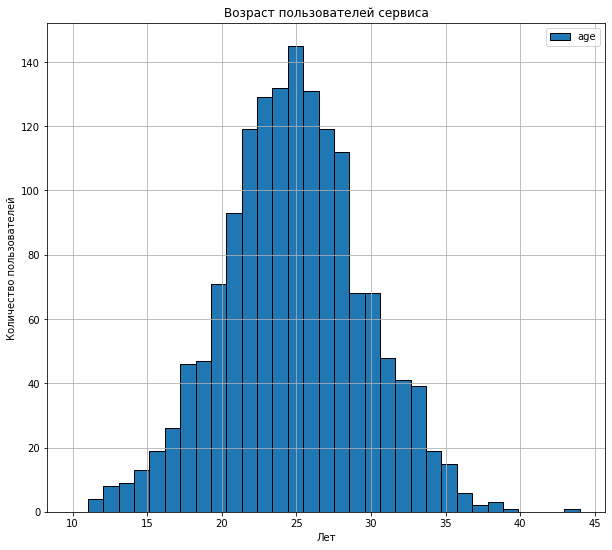

In [27]:
users['age'].hist(bins = 33,  range  = (10,44), figsize=(10, 9), ec='black', legend=True)
plt.title('Возраст пользователей сервиса')
plt.xlabel('Лет')
plt.ylabel('Количество пользователей')
plt.show()

Распределение возрастов пользователей близко к нормальному. Самый часто встречающийся возраст пользователя - 25 лет. Большая часть пользователей имеет возраст в пределах 22 - 28 лет. 

**Расстояние, которое пользователь преодолел за одну поездку.**

Аналогично данным о возрасте, снова вызовем таблицу со сводной статистикой данных о поездках, рассмотрим строку с расстояниями, пройденными пользователями за одну поездку.

In [28]:
rides.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,18068.0,842.869936,434.734317,1.000000,487.000000,889.000000,1213.250000,1534.000000
distance,18068.0,3070.659976,1116.831209,0.855683,2543.226360,3133.609994,3776.222735,7211.007745
duration,18068.0,17.805011,6.091051,0.500000,13.597563,17.678395,21.724800,40.823963
month,18068.0,6.486772,3.437410,1.000000,4.000000,6.000000,9.000000,12.000000


Как было отмечено ранее, минимальное расстояние, проезжаемое пользователями примерно 86 см, что может быть обусловлено нежеланием пользователя продолжать поездку или тем, что выбранный пользователем самокат мог быть разряженным. Медианное расстояние, проезжаемое пользователями сервися 3,134 км, а максимальное же - 7,211 км.  

Построим гистограмму распределения расстояний, пройденных пользователями за одну поездку.

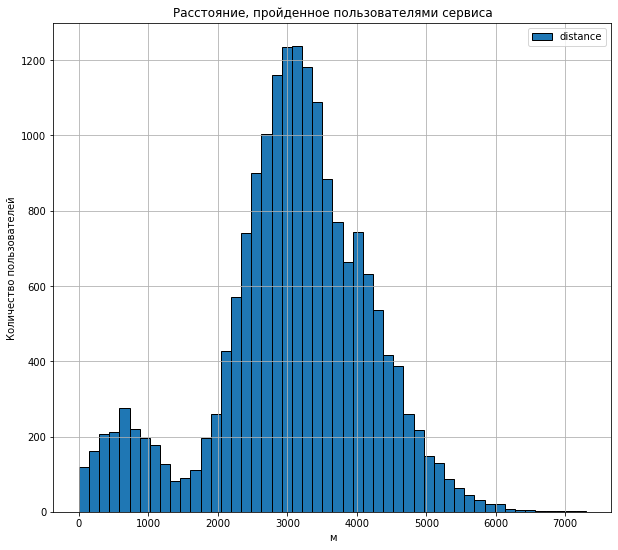

In [29]:
rides['distance'].hist(bins = 50,  range  = (0,7300), figsize=(10, 9), ec='black', legend=True)
plt.title('Расстояние, пройденное пользователями сервиса')
plt.xlabel('м')
plt.ylabel('Количество пользователей')
plt.show()

На визуализации отчетливо видно 2 колоколообразных распределения, близких к нормальному, с вершинами: для малого колокола около 700 м, для большого - 3,1 км. Два близких к нормальному распределения скорее всего соответствуют двум типам пользователей:
1. Пользователи, арендующие самокат для коротких поездок (до 1.5 км).
2. Пользователи, арендующие самокат для поездок на относительно длинные поездки (от 1.5 км и более).

Наибольшее число пользователей проезжают за одну поездку от 2,5 до 3,8 км. Наиболее часто встречающиеся расстояние, проходимое пользователями сервиса 3.1 км. Что соответствует медианному значению из таблицы с описательной статистикой. 

**Продолжительность поездок.**

Аналогично данным о возрасте, снова вызовем таблицу со сводной статистикой данных о поездках, рассмотрим строку с продолжительностью одной поездки.

In [30]:
rides.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,18068.0,842.869936,434.734317,1.000000,487.000000,889.000000,1213.250000,1534.000000
distance,18068.0,3070.659976,1116.831209,0.855683,2543.226360,3133.609994,3776.222735,7211.007745
duration,18068.0,17.805011,6.091051,0.500000,13.597563,17.678395,21.724800,40.823963
month,18068.0,6.486772,3.437410,1.000000,4.000000,6.000000,9.000000,12.000000


Наименьшее время поездки - полминуты. Наибольшее - почти 41 минута. Медианная продолжительность поездки - почти 18 минут.

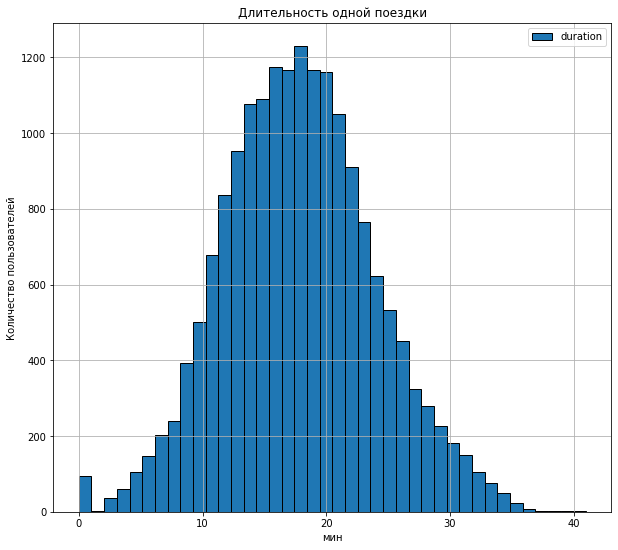

In [31]:
rides['duration'].hist(bins = 40,  range  = (0,41), figsize=(10, 9), ec='black', legend=True)
plt.title('Длительность одной поездки')
plt.xlabel('мин')
plt.ylabel('Количество пользователей')
plt.show()

На визуализации виден небольшой пик значений длительности поезки около 1 минуты. Исходя из расстояний, проезжаемых пользователями сервиса за одну поездку, можно сделать вывод, что это не выбросы, так как такая длительность поездки соответствует малым расстояниям, проходимым пользователями.

Длительность поездок имеет распределение, близкое к нормальному. Типичные поездки имеют длительность в диапазоне от 13 до 22 минут. Наиболее часто встречаются поездки длительностью 18 минут, что соотвествует медианному значению.

**Промежуточный вывод**

Пользователи равномерно распределились по городам. Есть небольшое смещение в двух городах. В Пятигорске количество пользователей - 219, в Москве - 168. 

Пользователей без подписки - 835 человек, с  подпиской - 699. Пользователей без подписки на 136 человек больше, чем с подпиской.

Минимальный возраст пользователя - 12 лет, а максимальный - 43 года. Медианный возраст пользователя - 25 лет. Наибольшее количество пользователей возрастом 22 - 28 лет.

Минимальное расстояние, проезжаемое пользователями примерно 86 см. Медианное расстояние, проезжаемое пользователями сервися 3,134 км, а максимальное же - 7,211 км. Наиболее часто продолеваемые пользователями растояния за одну поездку находятся в диапазоне от 2,5 до 3,8 км.
Исходя из визуализации можно предположить, что существуют два типа пользователей:
1. Пользователи, арендующие самокат для коротких поездок (до 1.5 км).
2. Пользователи, арендующие самокат для поездок на относительно длинные поездки (от 1.5 км и более).

Наименьшее время поездки - полминуты. Наибольшее - почти 41 минута. Медианная продолжительность поездки - почти 18 минут. Типичные поездки имеют длительность в диапазоне от 13 до 22 минут.

#### Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и типах подписок в один датафрейм.

In [32]:
full_data = users.merge(rides)
full_data = full_data.merge(subscriptions)
full_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Проверка корректности объединения файлов. Определим количество строк в файле rides до объединения и в full_data после объединения. А так же посмотрим количество уникальных пользователей в users до объединения и в объединённой таблице full_data.

In [33]:
print("Количество поездок в файле 'rides':", rides['user_id'].count())
print("Количество поездок в объединенном датасете 'full_data':", full_data['user_id'].count())
print()
print("Количество уникальных пользователей в 'users':", len(users['user_id'].unique()))
print("Количество уникальных пользователей в 'full_data':", len(full_data['user_id'].unique()))

Количество поездок в файле 'rides': 18068
Количество поездок в объединенном датасете 'full_data': 18068

Количество уникальных пользователей в 'users': 1534
Количество уникальных пользователей в 'full_data': 1534


Количества строк и уникальных пользователй в объединённой таблице совпадают с исходными данными. Т.е. совокупный размер датафрейма совпадает с количеством строк в исходной таблице

Определим количество дубликатов и пропусков в объединённой таблице:

In [34]:
full_data.duplicated().sum()

0

In [35]:
full_data.isna().sum().sum()

0

Дубликаты и пропущенные значения не обнаружены.

Создаём датафрейм c данными о пользователях без подписки.

In [36]:
free_data = full_data.query('subscription_fee == 0')
free_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Создаём датафрейм c данными о пользователях c подпиской.

In [37]:
fee_data = full_data.query('subscription_fee != 0')
fee_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


**Визуализируем информацию о расстоянии и времени поездок для пользователей без подписки  на сервис.**

Описательная статистика общих данных для пользователей без продписки.

In [38]:
free_data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,11568.0,1120.527230,241.165628,700.000000,915.000000,1123.000000,1328.000000,1534.000000
age,11568.0,24.893326,4.481100,12.000000,22.000000,25.000000,28.000000,43.000000
distance,11568.0,3045.495282,1246.173806,0.855683,2366.562689,3114.648465,3905.697894,7211.007745
duration,11568.0,17.390909,6.326803,0.500000,12.958437,17.326890,21.594071,34.948498
month,11568.0,6.522994,3.449770,1.000000,4.000000,7.000000,9.000000,12.000000
minute_price,11568.0,8.000000,0.000000,8.000000,8.000000,8.000000,8.000000,8.000000
start_ride_price,11568.0,50.000000,0.000000,50.000000,50.000000,50.000000,50.000000,50.000000
subscription_fee,11568.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Минимальное расстояние, пройденное за одну поезду, - 0.86 м, максимальное 7211 м, медианное - 3115 м. 
Минимальная продолжительность поездки 0.5 мин, максимальная 35 мин. Медианная продолжительность поездки для пользователей без подписки 17 мин.

Описательная статистика общих данных для пользователей с продпиской.

In [39]:
fee_data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,6500.0,348.725385,201.099339,1.000000,175.000000,351.000000,525.000000,699.000000
age,6500.0,24.892615,4.757208,12.000000,22.000000,25.000000,28.000000,38.000000
distance,6500.0,3115.445388,836.895330,244.210438,2785.444017,3148.637229,3560.574425,5699.769662
duration,6500.0,18.541985,5.572048,3.760353,14.524654,18.178153,21.884129,40.823963
month,6500.0,6.422308,3.414616,1.000000,4.000000,6.000000,9.000000,12.000000
minute_price,6500.0,6.000000,0.000000,6.000000,6.000000,6.000000,6.000000,6.000000
start_ride_price,6500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
subscription_fee,6500.0,199.000000,0.000000,199.000000,199.000000,199.000000,199.000000,199.000000


Минимальное расстояние, пройденное пользователями с подпиской - 244 м, максимальное - 5700 м. Медианное значение - 3148 м.

Минимальная длительность поездки - менее 4 мин, максимальная - почти 41 мин. Медианное значение длительности поезки -  чуть больше 18 мин.

Построим гистограмму распределения расстояния пройденного пользователями с подпиской и без неё

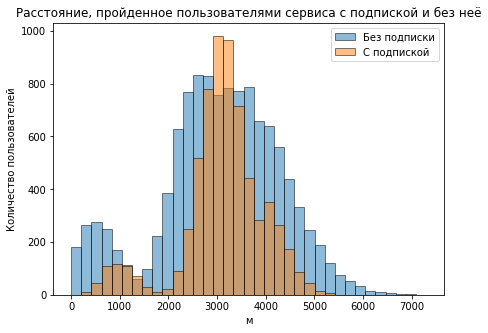

In [40]:
plt.figure(figsize=(7, 5))
plt.hist(free_data['distance'],
         bins = 35,
         ec='black',
         range  = (0,7300),
         alpha=0.5, 
         label='Без подписки') 
  
plt.hist(fee_data['distance'], 
         bins = 35,
         ec='black',
         range  = (0,7300),
         alpha=0.5, 
         label='С подпиской') 
  
plt.legend(loc='best') 
plt.title('Расстояние, пройденное пользователями сервиса с подпиской и без неё') 
plt.xlabel('м')
plt.ylabel('Количество пользователей')

plt.show()

**Для пользователей без подписки:**
На визуализации отчетливо видно 2 колоколообразных распределения, близких к нормальному, с вершинами: для малого колокола около 700 м, для большого - 2,9 км. Два близких к нормальному распределения скорее всего соответствуют двум типам пользователей:

1. Пользователи, арендующие самокат для коротких поездок (до 1.3 км).
2. Пользователи, арендующие самокат для поездок на относительно длинные поездки (от 1.3 км и более).

Наибольшее число пользователей проезжают за одну поездку от 2,4 до 3,9 км. Наиболее часто встречающиеся расстояние, проходимое пользователями сервиса без подписки 2.9 км. Что не полностью соответствует медианному значению из таблицы с описательной статистикой, медиана и среднее смещены в сторону больших значений.

**Для пользователей с подпиской:**
На визуализации отчетливо видно 2 колоколообразных распределения, близких к нормальному, с вершинами: для малого колокола около 1.0 км, для большого - 3,1 км. 
Как и у пользователей без подписки наблюдаются 2 пика в распределении растояний, пройденных пользователями сервиса, так же можно предположить, что это две группы пользователей:

1. Пользователи, арендующие самокат для коротких поездок (до 1.9 км).
2. Пользователи, арендующие самокат для поездок на относительно длинные поездки (от 2.0 км и более).

Наибольшее число пользователей проезжают за одну поездку от 2,5 до 3,6 км. Наиболее часто встречающиеся расстояние, проходимое пользователями сервиса 3.1 км. Что соответствует медианному значению из таблицы с описательной статистикой.

Построим гистограмму распределения длительности одной поездки пользователей с подпиской и без неё

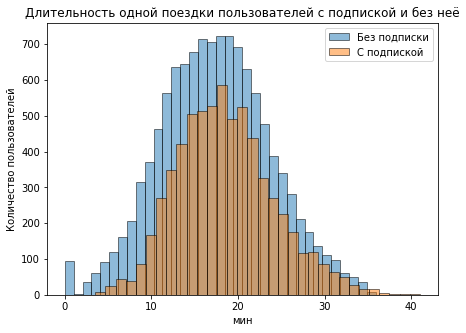

In [41]:
plt.figure(figsize=(7, 5))
plt.hist(free_data['duration'],
         bins = 40,
         ec='black',
         range  = (0,41),
         alpha=0.5, 
         label='Без подписки') 
  
plt.hist(fee_data['duration'], 
         bins = 35,
         ec='black',
         range  = (0,41),
         alpha=0.5, 
         label='С подпиской') 
  
plt.legend(loc='best') 
plt.title('Длительность одной поездки пользователей с подпиской и без неё') 
plt.xlabel('мин')
plt.ylabel('Количество пользователей')

plt.show()

**Для пользователей без подписки:**

Длительность поездок пользователей без подписки имеет распределение, близкое к нормальному. Типичные поездки имеют длительность в диапазоне от 13 до 22 минут. Наиболее часто встречаются поездки длительностью 17 минут, что соотвествует медианному значению.

**Для пользователей с подпиской:**

Длительность поездок пользователей с подпиской имеет распределение, близкое к нормальному. Типичные поездки имеют длительность в диапазоне от 14 до 22 минут. Наиболее часто встречаются поездки длительностью 18 минут, что соотвествует медианному значению.

**Промежуточный вывод**

Для пользователей без подписки типичное время поездки составляет от 13 до 22 минуты, проезжая при этом от 2.4 до 3.9 км. Медианные значения времени поездки и расстояния, проезжаемого за 1 поедку составляют: 2.9 км и 17 мин. 

Для пользователей с подпиской типичное время поездки составляет от 14 до 22 минуты, проезжая при этом от 2.5 до 3.6 км. Медианные значения времени поездки и расстояния, проезжаемого за 1 поедку составляют: 3.1 км и 18 мин. 

Таким образом, можно сделать вывод, что пользователи с подпиской обладают более стабильным характером поездок, чем пользователи без подписки. А именно, у пользоватнелей с подпиской не наблюдается такого большого разброса в расстояниях и времени одной поездки, как у пользователей без подписки.

#### Шаг 5. Подсчёт выручки

Округлим до целого значения продолжительность одной поезки в датасете с полными данными.

In [42]:
full_data['duration']= np.ceil(full_data['duration']).astype(int) # округляем продолжительность поездки до целого числа - минут

Создаём датафрейм с агрегированными данными о поездках на основе датафрейма с общими данными.
Найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [43]:
total_pivot = full_data.pivot_table(index = ('user_id','month'), values = ('distance', 'duration','minute_price','start_ride_price','subscription_fee'), aggfunc = {'count', 'sum'})
total_pivot.columns = ['count','distance', '1','duration','2','minute_price', '3', 'start_ride_price','4', 'subscription_fee']# переименовываем столбцы
total_pivot = total_pivot.drop(['1','2','3','4'],axis = 1)#избавляемся от повторяющихся столбцов
total_pivot.head(20)

count      distance  duration  minute_price  start_ride_price  \
user_id month                                                                  
1       1          2   7027.511294        42            12                 0   
        4          1    754.159807         7             6                 0   
        8          2   6723.470560        46            12                 0   
        10         2   5809.911100        32            12                 0   
        11         3   7003.499363        56            18                 0   
        12         2   6751.629942        28            12                 0   
2       3          3  10187.723006        63            18                 0   
        4          2   6164.381824        40            12                 0   
        6          1   3255.338202        14             6                 0   
        7          2   6780.722964        48            12                 0   
        8          1    923.007439         7             6                 0   
        10         1   2824.636598        19             6                 0   
        12         1   3828.248580        12             6                 0   
3       1          1   3061.777147        13             6                 0   
        2          2   5421.152016        39            12                 0   
        4          1   2956.651632        21             6                 0   
        5          3   9064.026918        63            18                 0   
        7          3  10919.595403        67            18                 0   
        9          1   2891.012822        23             6                 0   
        12         1   2593.381928        13             6                 0   

               subscription_fee  
user_id month                    
1       1                   398  
        4                   199  
        8                   398  
        10                  398  
        11                  597  
        12                  398  
2       3                   597  
        4                   398  
        6                   199  
        7                   398  
        8                   199  
        10                  199  
        12                  199  
3       1                   199  
        2                   398  
        4                   199  
        5                   597  
        7                   597  
        9                   199  
        12                  199

Перезададим значения цен, так как при повторном заказе самоката, цена остаётся фиксированной. 

In [44]:
total_pivot['minute_price'] = total_pivot['minute_price']/total_pivot['count']
total_pivot['start_ride_price'] = total_pivot['start_ride_price']/total_pivot['count']
total_pivot['subscription_fee'] = total_pivot['subscription_fee']/total_pivot['count']
total_pivot.head(20)

count      distance  duration  minute_price  start_ride_price  \
user_id month                                                                  
1       1          2   7027.511294        42           6.0               0.0   
        4          1    754.159807         7           6.0               0.0   
        8          2   6723.470560        46           6.0               0.0   
        10         2   5809.911100        32           6.0               0.0   
        11         3   7003.499363        56           6.0               0.0   
        12         2   6751.629942        28           6.0               0.0   
2       3          3  10187.723006        63           6.0               0.0   
        4          2   6164.381824        40           6.0               0.0   
        6          1   3255.338202        14           6.0               0.0   
        7          2   6780.722964        48           6.0               0.0   
        8          1    923.007439         7           6.0               0.0   
        10         1   2824.636598        19           6.0               0.0   
        12         1   3828.248580        12           6.0               0.0   
3       1          1   3061.777147        13           6.0               0.0   
        2          2   5421.152016        39           6.0               0.0   
        4          1   2956.651632        21           6.0               0.0   
        5          3   9064.026918        63           6.0               0.0   
        7          3  10919.595403        67           6.0               0.0   
        9          1   2891.012822        23           6.0               0.0   
        12         1   2593.381928        13           6.0               0.0   

               subscription_fee  
user_id month                    
1       1                 199.0  
        4                 199.0  
        8                 199.0  
        10                199.0  
        11                199.0  
        12                199.0  
2       3                 199.0  
        4                 199.0  
        6                 199.0  
        7                 199.0  
        8                 199.0  
        10                199.0  
        12                199.0  
3       1                 199.0  
        2                 199.0  
        4                 199.0  
        5                 199.0  
        7                 199.0  
        9                 199.0  
        12                199.0

В этот же датафрейм добавляем столбец с помесячной выручкой, которую принёс каждый пользователь. 

In [45]:
total_pivot['proceeds'] = ((total_pivot['start_ride_price']*total_pivot['count'])+(total_pivot['minute_price']*total_pivot['duration'])+total_pivot['subscription_fee'])
total_pivot.head(10)

count      distance  duration  minute_price  start_ride_price  \
user_id month                                                                  
1       1          2   7027.511294        42           6.0               0.0   
        4          1    754.159807         7           6.0               0.0   
        8          2   6723.470560        46           6.0               0.0   
        10         2   5809.911100        32           6.0               0.0   
        11         3   7003.499363        56           6.0               0.0   
        12         2   6751.629942        28           6.0               0.0   
2       3          3  10187.723006        63           6.0               0.0   
        4          2   6164.381824        40           6.0               0.0   
        6          1   3255.338202        14           6.0               0.0   
        7          2   6780.722964        48           6.0               0.0   

               subscription_fee  proceeds  
user_id month                              
1       1                 199.0     451.0  
        4                 199.0     241.0  
        8                 199.0     475.0  
        10                199.0     391.0  
        11                199.0     535.0  
        12                199.0     367.0  
2       3                 199.0     577.0  
        4                 199.0     439.0  
        6                 199.0     283.0  
        7                 199.0     487.0

**Промежуточный вывод**

Создан датафрейм с агрегированными данными о поездках на основе датафрейма с общими данными: найдены суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

В этот же датафрейм добавлен столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого воспользовались информацией об условиях оплаты для подписчиков и тех, у кого нет подписки. 

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.
1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

**Гипотеза 1.**

Нулевая гипотеза H0: Средние продолжительности поездок пользователей с подпиской и без неё равны.

Альтернативная гипотеза Н1: Средняя продолжительность поездок пользователей с подпиской больше чем средняя продолжительность поездок пользователей без подписки.

In [46]:
alpha = 0.05
result1 = st.ttest_ind(fee_data['duration'],free_data['duration'], alternative = 'greater')
print('p-value:', result1.pvalue)
if result1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Так как нулевая гипотеза о равенстве средней продолжительности поездок пользователей с подпиской и без неё отвергнута, есть основания утверждать, что пользователи с подпиской действительно тратят больше времени на поездки, а значит, более выгодны для сервиса.

2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

**Гипотеза 2.**

Нулевая гипотеза H0: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку составляет 3130 метров.

Альтернативная гипотеза Н1: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку более 3130 метров.

In [47]:
value = 3130
result2 = st.ttest_1samp(fee_data['distance'], value, alternative = 'greater')
print('p-value:', result2.pvalue)
if result2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


Так как не удалось отвергнуть нулевую гипотезу о равенстве средний расстояний, пройденных пользователями без подписки и с подпиской , то нельзя сделать вывод, что пользователи с подпиской проезжают более 3130 м за одну поездку. Соответственно, пользователи с подпиской не совершают поездки, которые приводят к повышенному износу самоката. Соответственно, данная группа не создаёт дополнительную денежную нагрузку на сервис в виде дополнительных ремонтов и тех. обслуживаний самокатов. 

3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**Гипотеза 3.**

Нулевая гипотеза H0: Средняя помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.

Альтернативная гипотеза Н1: Средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем средняя помесячная выручка от пользователей без подписки.

In [48]:
ultra = total_pivot.loc[total_pivot.start_ride_price == 0, 'proceeds'] 

free = total_pivot.loc[total_pivot.start_ride_price != 0, 'proceeds'] 


result3 = st.ttest_ind(ultra, free, alternative = 'greater')

print('p-value:', result3.pvalue)

if result3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Так как отвергаем нулевую гипотезу о равенстве средней помесячной выручки от пользователей с под пиской и без неё, делаем вывод, что средняя помесячная выручка с пользователей с подпиской превышает среднюю помесячную выручку с пользователей без неё. То есть пользователи с подпиской более выгодны для сервиса проката самокатов.

4. Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки данной гипотезы воспользуемся двухвыборочным t - тестом для зависимых выборок. О равенстве среднего значения генеральной совокупности до и после изменения.

Гипотезы будут сформулированы так:

H0 : μ1 = μ2

H1 : μ1 > μ2

где μ1 и μ2 - средние значения количества обращений в техподдержку до и после обновления серверов.

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применяют метод scipy.stats.ttest_rel().

#### Шаг 7. Распределения

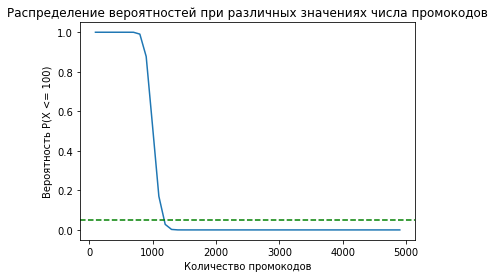

Минимальное количество промокодов: 1200


In [53]:
p = 0.1
q = 1 - p
fail_prob= 0.05

n_values = range(100, 5000, 100) # Приближаемся к значению требуемого числа промокодов с шагом 100

probab = []
for n in n_values:
    distr = binom(n, p)
    probabil = distr.cdf(100) # Вероятность P(X <= 100)
    probab.append(probabil)

# График распределения
plt.plot(n_values, probab)
plt.xlabel('Количество промокодов')
plt.ylabel('Вероятность P(X <= 100)')
plt.title('Распределение вероятностей при различных значениях числа промокодов')
plt.axhline(y=fail_prob, color='g', linestyle='--') # Горизонтальная линия для ограничения вероятности
plt.show()

# Поиск минимального значения числа промокодов, удовлетворяющего ограничению
min_n = n_values[probab.index(next(prob for prob in probab if prob <= fail_prob))]

print(f'Минимальное количество промокодов: {min_n}')

1. Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. 

Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 

Для выполнения условия - "как минимум 100 существующих клиентов должны продлить эту подписку", требуется разослать 1200 промокодов, чтобы вероятность не выполнить план была примерно 5 %.

2. Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. Требуется оценить вероятность, что  уведомление откроют не более 399,5 тыс. пользователей.

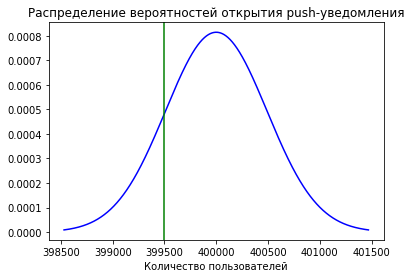

Bероятность, что  уведомление откроют не более 399,5 тыс. пользователей: 0.15371708296369768


In [50]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

mu = n * p
sigma = (n * p * (1-p)) ** 0.5
distr = st.norm(mu, sigma) 
prob = distr.cdf(399500)

arange = np.arange((mu - 3 * sigma), (mu + 3 * sigma), 1)
plt.plot(arange, norm.pdf(arange, mu,sigma), 'b-')#Массив arange определяет диапазон для оси x, а plt.plot() создает кривую для нормального распределения с указанным средним значением и стандартным отклонением.
plt.axvline(x=399500, color='green')
plt.xlabel('Количество пользователей')
plt.title('Распределение вероятностей открытия push-уведомления')
plt.show()

print(f'Bероятность, что  уведомление откроют не более 399,5 тыс. пользователей: {prob}')


Если разослать 1 млн. уведомлений, которые открывают клиенты с вероятностью 40%, то 399.5 тыс. клиентов откроют их с вероятностью 15.37%. 

#### Общий вывод

В данной работе исследованы данные сервиса проката самокатов GoFast. А именно: данные о некоторых пользователях из нескольких городов, а также об их поездках. 

Цели исследования: проанализировать данные и проверить следующие гипотезы, которые могут помочь бизнесу вырасти:
- Пользователи с подпиской тратят больше времени на поездки, чем пользователи без неё.
- Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.
- Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

Для решения данных задач были выполнены: 
1. Загружены библиотеки для работы с данными, загружены сами данные, выведена общая информация о каждом из датасетов.
2. Проведена предобработка данных. Проверка наличия пропусков - пропуски не обнаружены. Обработаны дубликаты - удалены дубликаты в файле users, неявные дубликаты в файлах с данными не обнаружены. Приведен к формату datetime столбец с датой в датасете rides_go.csv. Добавлен столбец с номером месяца в данный датасет.
3. Проведён исследовательский анализ данных.
- Оценены и визуализированы частота встречаемости городов, соотношение пользователей с подпиской и без подписки, возраст пользователей, расстояние, которое пользователь преодолел за одну поездку и продолжительность поездок. Построены гистограммы и круговая диаграмма для каждого из перечисленных пунктов.
4. Объединены данные из трёх датасетов в один общий. После чего на его основе созданы два датасета с данными о пользователях с подпиской и без неё. Визуализирована информацию о расстоянии и времени поездок для пользователей обеих категорий гистограммами.
5. Произведен подсчёт выручки. Создана сводная таблица о суммарном расстоянии, количестве поездок и суммарном времени для каждого пользователя за каждый месяц. Добавлен столбец в данную таблицу с помесячной выручкой, но пред этим произведено округление значений в столбце с продолжительностью поездки.
6. Произведена проверка гипотез с помощью t-тестов:
- Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе
- Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку
- Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки
7. Определено минимальное количество промокодов, которые нужно разослать, чтобы как минимум 100 существующих клиентов должны продлить эту подписку и вероятность не выполнить план была примерно 5 %. А так же, оценена вероятность того, что уведомление откроют не более 399,5 тыс. пользователей из 1 млн разосланный уведомлений с вероятностью открытия 40%. 

Из проделанной работы можно сделать следующие выводы:

Пользователи равномерно распределились по городам. Есть небольшое смещение в двух городах. В Пятигорске количество пользователей - 219, в Москве - 168. В Пятигорске большее количество пользователей, скорее всего, обусловлено тем, что, это небольшой курортный город, в котором туристам удобнее передвигаться между достопримечательностями на самокате. В Москве же меньшее количество пользователее, скорее обусловлено, тем, что в столице существуют и другие сервисы проката самокатов, соответственно присутствует конкуренция за пользователей. 

Пользователей без подписки - 835 человек, с  подпиской - 699. Пользователей без подписки на 136 человек больше, чем с подпиской.
Минимальный возраст пользователя - 12 лет, а максимальный - 43 года. Медианный возраст пользователя - 25 лет. Наибольшее количество пользователей возрастом 22 - 28 лет.

Минимальное расстояние, проезжаемое пользователями примерно 86 см. Медианное расстояние, проезжаемое пользователями сервися 3,134 км, а максимальное же - 7,211 км. Наиболее часто продолеваемые пользователями растояния за одну поездку находятся в диапазоне от 2,5 до 3,8 км.
Исходя из визуализации можно предположить, что существуют два типа пользователей:
1. Пользователи, арендующие самокат для коротких поездок (до 1.5 км).
2. Пользователи, арендующие самокат для поездок на относительно длинные поездки (от 1.5 км и более).

Наименьшее время поездки - полминуты. Наибольшее - почти 41 минута. Медианная продолжительность поездки - почти 18 минут. Типичные поездки имеют длительность в диапазоне от 13 до 22 минут.

Для пользователей без подписки типичное время поездки составляет от 13 до 22 минуты, проезжая при этом от 2.4 до 3.9 км. Медианные значения времени поездки и расстояния, проезжаемого за 1 поедку составляют: 2.9 км и 17 мин. 

Для пользователей с подпиской типичное время поездки составляет от 14 до 22 минуты, проезжая при этом от 2.5 до 3.6 км. Медианные значения времени поездки и расстояния, проезжаемого за 1 поедку составляют: 3.1 км и 18 мин. 

Таким образом, можно сделать вывод, что пользователи с подпиской обладают более стабильным характером поездок, чем пользователи без подписки. А именно, у пользоватнелей с подпиской не наблюдается такого большого разброса в расстояниях и времени одной поездки, как у пользователей без подписки.

Результаты проверки гипотез:
1. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без неё.

Нулевая гипотеза H0: Средние продолжительности поездок пользователей с подпиской и без неё равны.

Альтернативная гипотеза Н1: Средняя продолжительность поездок пользователей с подпиской больше чем средняя продолжительность поездок пользователей без подписки.

Так как нулевая гипотеза о равенстве средней продолжительности поездок пользователей с подпиской и без неё отвергнута, есть основания утверждать, что пользователи с подпиской действительно тратят больше времени на поездки, а значит, более выгодны для сервиса.

2. Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.

Нулевая гипотеза H0: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку составляет 3130 метров.

Альтернативная гипотеза Н1: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку более 3130 метров.

Так как не удалось отвергнуть нулевую гипотезу о равенстве средний расстояний, пройденных пользователями без подписки и с подпиской , то нельзя сделать вывод, что пользователи с подпиской проезжают более 3130 м за одну поездку. Соответственно, пользователи с подпиской не совершают поездки, которые приводят к повышенному износу самоката. Соответственно, данная группа не создаёт дополнительную денежную нагрузку на сервис в виде дополнительных ремонтов и тех. обслуживаний самокатов. 

3. Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

Нулевая гипотеза H0: Средняя помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.

Альтернативная гипотеза Н1: Средняя помесячная выручка от пользователей с подпиской по месяцам выше, чем средняя помесячная выручка от пользователей без подписки.

Так как отвергаем нулевую гипотезу о равенстве средней помесячной выручки от пользователей с под пиской и без неё, делаем вывод, что средняя помесячная выручка с пользователей с подпиской превышает среднюю помесячную выручку с пользователей без неё. То есть пользователи с подпиской более выгодны для сервиса проката самокатов.

Исходя из результатов проверки статистических гипотез, описанных выше, можно сделать вывод, что пользователи с подпиской на сервис проката более выгодня для бизнеса, так как в среднем проезжают бóльшие расстояния, чем пользователи без подписки. При этом среднее расстояние, пройденное пользователями с подпиской не превышает 3130 м - оптимального с точки зрения износа самоката. К тому же средняя помесячная выручка с пользователей с подпиской превышает среднюю помесячную выручку с пользователей без неё.

Определено минимальное количество промокодов, которые нужно разослать, чтобы как минимум 100 существующих клиентов продлят эту подписку и вероятность не выполнить план была примерно 5 % = 1200 шт.

Оценена вероятность того, что уведомление откроют не более 399,5 тыс. пользователей из 1 млн разосланный уведомлений с вероятностью открытия 40% = 15.37%